# Телекоммуникации. Предсказание оттока клиентов

## Описание проекта

Необходимо обучить модель, которая будет выявлять клиентов, которые планируют отказаться от услуг связи.

**Описание данных**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Информация о договорах актуальна на 1 февраля 2020 года.

Данные состоят из нескольких файлов, полученных из разных источников:

**Файл `contract_new.csv`, содержащий информацию о договоре**
* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv` содержит персональные данные клиента**
* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv` содержит информацию об интернет-услугах**
* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv` содержит иформацию об услугах телефонии**
* `customerID` — идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

### Импорты библиотек и объявление констант

In [1]:
!pip install phik shap catboost -q
!pip install -U scikit-learn -q
!pip install -U matplotlib -q

In [2]:
# загружаем библиотеки
import numpy as np
import pandas as pd
import phik
import re
import warnings

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn import set_config

# загружаем классы для подготовки данных
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# библиотеки для обучения моделей
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, precision_score,
    auc, confusion_matrix, roc_curve, roc_auc_score
)

In [3]:
# скрываем вывод предупреждений
warnings.filterwarnings('ignore')

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# вывод графиков
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (15,5)

# объявляем константы
RANDOM_STATE = 100225
TEST_SIZE = 0.25
ACTUAL_DATE = pd.to_datetime('2020-02-01')

### Полезные функции

In [4]:
# функция для загрузки csv-файлов
def data_import(file_name: str) -> pd.DataFrame:
    '''
    input: название файла без расширения
    output: название файла, первые 5 строк и сводную информацию датафрейма
    return: датафрейм
    '''
    
#     локальный путь файла
    pth_1 = '/datasets/' + file_name + '.csv'
#     серверный путь файла
    server_pth = 'https://example.ru/' + file_name + '.csv'

#     для файла contract_new
    if file_name == 'contract_new':
        try:
            data = pd.read_csv(pth_1, parse_dates=['BeginDate', 'EndDate'], index_col='customerID')
        except:
            data = pd.read_csv(server_pth, parse_dates=['BeginDate', 'EndDate'], index_col='customerID')
    else:
        try:
            data = pd.read_csv(pth_1, index_col='customerID')
        except:
            data = pd.read_csv(server_pth, index_col='customerID')
    
#     приводим названия к змеиному регистру
    data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower(), inplace=True)
    
#     выводим данные о датафрейме
    print(f'Информация о DataFrame — {file_name}')
    print()
    display(data.head())
    print(data.info())
    print('-' * 50)
    
    return data

In [5]:
def data_info(data):
    """
    Выводит уникальные значения признаков типа ['object', 'category'] датафрейма
    Выводит уникальные значения числовых признаков, если уникальных значений меньше 10
    """
    for _ in data.select_dtypes(include=['object', 'category']).columns:
        print(_)
        print(data[_].sort_values().unique())
        print('-' * 30)
    for _ in data.select_dtypes(exclude=['object', 'category']).columns:
        if data[_].nunique() < 10:
            print(_)
            print(data[_].unique())
            print('-' * 30)

In [6]:
# Функция для визуализации пропусков данных
def pass_value_barh(df):
    """
    Принимает pd.df, выдает список колонок с пропусками
    Выводит график
    """
    try:
        pass_part = (
            (df.isna().mean()*100) # находим долю пропусков
            .round(2)
            .to_frame()
            .rename(columns = {0:'part'})
            .query('part > 0') # если есть пропуски, то выводим
            .sort_values(by = 'part', ascending = True))
#         Строим распределение столбиком 'лежа'
        pass_part.plot(kind = 'barh', figsize = (10,5), legend = False)
#         Выводим долю пропусков для каждого атрибута
        for index, value in enumerate(pass_part.part):
            plt.text(value, index, str(round(value, 1)));         
        plt.title('Пропущенные значения\n')
        plt.xlabel('\nКол-во пропусков, %')
        plt.ylabel('Столбцы с пропусками\n')
        plt.xlim(0, 100)  
        
#         возвращаем список названий столбцов с пропусками
        return pass_part.index.to_list()
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

In [7]:
def add_difference(x, y):
    '''
    Добавляет разницу (x - y) между таймстемпами
    '''
    if x != 'No':
        x = pd.to_datetime(x)
        difference = x - y
    else:
        difference = ACTUAL_DATE - y
    return difference

In [8]:
def gscv_fit(estimator, param_grid, model_name, cv=3):
    """
подбор гиперпараметров
input: estimator, param_grid, model_name, cv=3
return: fitted GridSearchCV
    """
    gscv = GridSearchCV(estimator, param_grid,
                        scoring=['roc_auc', 'recall'], refit='roc_auc', error_score='raise',
                        cv=cv, n_jobs=-1, verbose=1)
    gscv.fit(X_train, y_train)
    preds = gscv.best_estimator_.predict(X_train)
    
    cv_res_df = pd.DataFrame(gscv.cv_results_)
    cv_res_df = cv_res_df.set_index('rank_test_roc_auc').sort_index()
    cols = ['params',
            'mean_fit_time',
            'mean_test_roc_auc', 'std_test_roc_auc',
            'mean_test_recall', 'rank_test_recall']
    
    print('Best CV fits')
    display(cv_res_df[cols].head())
    print('-' * 30)
    
    global models_results
    models_results = models_results.append({
        'model_name': model_name,
        'params': gscv.best_params_,
        'roc_auc': gscv.best_score_,
        'recall': cv_res_df.loc[1,'mean_test_recall'],
        'time': gscv.refit_time_
    }, ignore_index=True)
#     display(models_results)

    return gscv

## Загрузка данных

In [9]:
# загрузим файлы
contract_new = data_import('contract_new')
personal_new = data_import('personal_new')
internet_new = data_import('internet_new')
phone_new = data_import('phone_new')

Информация о DataFrame — contract_new



,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB
None
---------------------------------------------------------------------------------------------
Информация о DataFrame — personal_new



,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None
---------------------------------------------------------------------------------------------
Информация о DataFrame — internet_new



,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_t_v      5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None
---------------------------------------------------------------------------------------------
Информация о DataFrame — phone_new



,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None
---------------------------------------------------------------------------------------------


In [10]:
# переименуем колонку с TV
internet_new.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)

***Промежуточные выводы:***
1. Ни один из файлов не содержит пропусковю, но можно заметить, что количество записей в таблицах не совпадает. Стоить учесть этот факт при объединении таблиц – объединение внешних областей.
2. Признаки `end_date`, `total_charges` типизированы как `object`, значит в них, вероятно, содержатся строковые значения.
3. Все признаки кроме `senior_citizen` содержат записи в виде строк, тогда как здесь все записи числовые.

## Анализ и предобработка данных

In [11]:
# словарь цветов для графиков
colors = {
    'No':'C3', 'Yes':'C2',
    'Male':'C1', 'Female':'C4',
    'DSL':'C5', 'Fiber optic':'C6', 'unknown': 'C7',
    'Month-to-month': 'C1', 'One year': 'C4', 'Two year': 'C5',
    'Electronic check': 'C1', 'Mailed check': 'C4', 'Bank transfer (automatic)': 'C5', 'Credit card (automatic)':'C6',
    0: 'C1', 1: 'C4', 2: 'C5', 3:'C6', 4:'C7', 5:'C8', 6:'C9'}

### Исследовательский анализ и предобработка данных

***1. `contract_new`***

Пройдемся по записям признаков `total_charges` и `end_date`.

In [12]:
#  выведем уникальные значения признаков 'object'
data_info(contract_new)

end_date
['2014-06-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-01' '2019-06-01' '2019-07-01'
 '2019-08-01' '2019-09-01' '2019-10-01' '2019-11-01' '2019-12-01'
 '2020-01-01' 'No']
-------------------------------
type
['Month-to-month' 'One year' 'Two year']
-------------------------------
pap

Признак `total_charges` содержит одно строковое значение. Выведем данные с этим значением признака.

In [13]:
contract_new.query('total_charges == " "')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.550,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.250,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.850,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.750,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.050,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.850,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.350,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.000,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.700,


Можно заметить, что вся информация представлена новыми клиентами. Можно заменить пропуски значением ежемесячного платежа.

In [14]:
indexes = contract_new.query('total_charges == " "').index
contract_new.loc[indexes, 'total_charges'] = contract_new.loc[indexes, 'monthly_charges'].copy()
contract_new.total_charges = contract_new.total_charges.astype('float')
contract_new.loc[indexes]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.550,52.550
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.250,20.250
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.850,80.850
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.750,25.750
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.050,56.050
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.850,19.850
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.350,25.350
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.000,20.000
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.700,19.700


Признак `end_date` содержит заглушку в виде строки. Из этого признака можно достать целевой признак, а также можно из признаков с датами достать длительность действия договора, если договор действует, то в качестве второй даты используем дату сбора данных.

In [15]:
# добавим таргет из признака "end_date"
contract_new['target'] = contract_new['end_date'].apply(lambda x: 'Yes' if x != 'No' else x)

# создаем колонку с продолжительностью действия договора
contract_new['contract_duration'] = contract_new.apply(
    lambda row: add_difference(row['end_date'], row['begin_date']), axis=1).dt.days

# выводим сэмплы
contract_new.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,contract_duration
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,31.040,No,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,"2,071.840",No,1036
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850,226.170,No,123
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,"1,960.600",No,1371
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700,353.500,No,153
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.650,"1,150.960",No,337
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.100,"2,058.210",No,671
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750,300.480,No,306
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.800,"3,573.680",No,945


Теперь можно удалить признаки с датами.

In [16]:
# удалим колонки с датами
contract_new.drop(['begin_date', 'end_date'], axis=1, inplace=True)
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   target             7043 non-null   object 
 6   contract_duration  7043 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 698.2+ KB


Выведем распределение признаков таблиц.

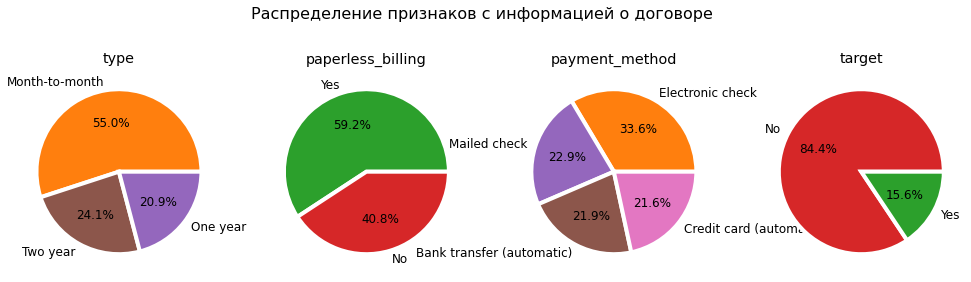

In [17]:
# распределение категориальных признаков
fig, axs = plt.subplots(1,4)
fig.tight_layout(pad=4)
plt.subplots_adjust(wspace=0.2)
fig.suptitle('Распределение признаков с информацией о договоре', fontsize=16)
for i,_ in enumerate(contract_new.select_dtypes(include='object').columns):
    axs[i].pie(
        contract_new[_].value_counts(),
        labels=contract_new[_].value_counts().index,
        colors=[colors[key] for key in contract_new[_].value_counts().index],
        autopct='%1.1f%%', radius=1,
        wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'});
    axs[i].set_title(_)

Из графиков видно, что имеется дисбаланс классов в целевом признаке.

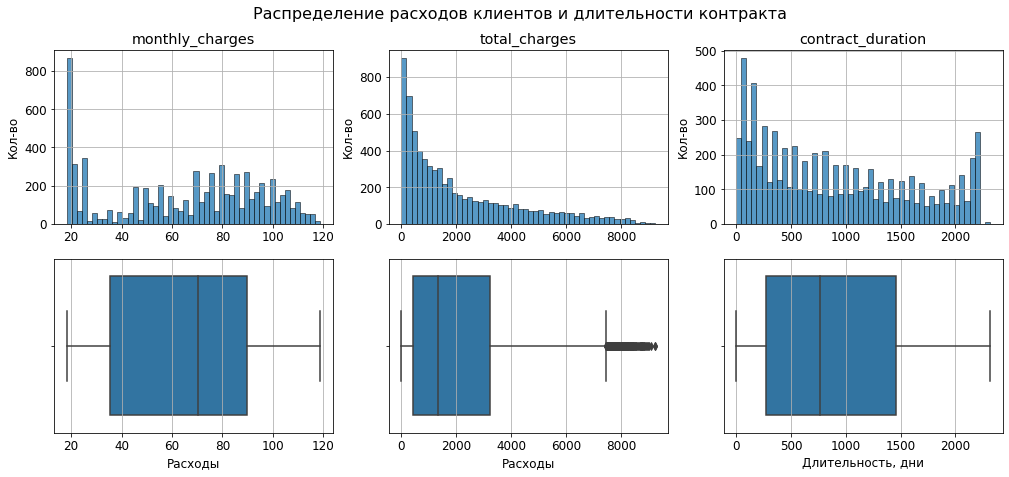

In [18]:
# распределение расходов клиентов
fig, axs = plt.subplots(2,3, figsize=(15,7))
fig.tight_layout(pad=4)
plt.subplots_adjust(hspace=0.2, wspace=0.2)
fig.suptitle('Распределение расходов клиентов и длительности контракта', fontsize=16)
for i,_ in enumerate(contract_new.select_dtypes(exclude='object').columns):
    sns.histplot(x=contract_new[_], bins=50, ax=axs[0,i])
    axs[0,i].set_title(_)
    axs[0,i].set_xlabel('')
    axs[0,i].set_ylabel('Кол-во')
    sns.boxplot(x=contract_new[_], ax=axs[1,i])
    axs[1,i].set_xlabel('Расходы')
    axs[1,2].set_xlabel('Длительность, дни')
plt.show()

Ежемесячные расходы клиентов имеют 2 "пика". Общие расходы клиентов убывают.

***2. `personal_new`***

In [19]:
#  выведем уникальные значения признаков 'object'
data_info(personal_new)

gender
['Female' 'Male']
-------------------------------
partner
['No' 'Yes']
-------------------------------
dependents
['No' 'Yes']
-------------------------------
senior_citizen
[0 1]
-------------------------------


Для удобства заменим целочисленные значения признака `senior_citizen` строковыми.

In [20]:
# приведем значения колонки "senior_citizen" с  "0" и "1" к "No" и "Yes"
personal_new.senior_citizen.replace({0:'No', 1:'Yes'}, inplace=True)

In [21]:
display(personal_new.head())
personal_new.info()

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,No,Yes,No
5575-GNVDE,Male,No,No,No
3668-QPYBK,Male,No,No,No
7795-CFOCW,Male,No,No,No
9237-HQITU,Female,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   object
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


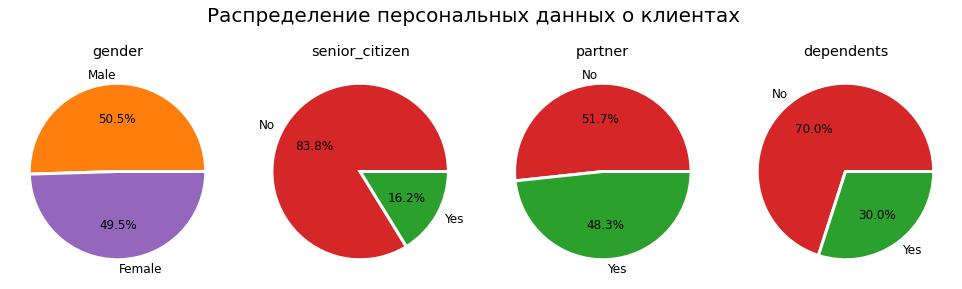

In [22]:
# распределение категориальных признаков
fig, axs = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout(pad=4)
plt.subplots_adjust(wspace=0.1)
fig.suptitle('Распределение персональных данных о клиентах', fontsize=20)
for i,_ in enumerate(personal_new.columns):
    axs[i].pie(
        personal_new[_].value_counts(),
        labels=personal_new[_].value_counts().index,
        colors=[colors[key] for key in personal_new[_].value_counts().index],
        autopct='%1.1f%%',
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'});
    axs[i].set_title(_)

В данных одинаковое количество женщин у мужчин.

***3. `internet_new`*** и ***4. `phone_new`***

Добавим признак, в котором соберем количеством подключенных услуг клиента.

In [23]:
#  выведем уникальные значения признаков 'object'
print(data_info(internet_new))
data_info(phone_new)

internet_service
['DSL' 'Fiber optic']
-------------------------------
online_security
['No' 'Yes']
-------------------------------
online_backup
['No' 'Yes']
-------------------------------
device_protection
['No' 'Yes']
-------------------------------
tech_support
['No' 'Yes']
-------------------------------
streaming_tv
['No' 'Yes']
-------------------------------
streaming_movies
['No' 'Yes']
-------------------------------
None
multiple_lines
['No' 'Yes']
-------------------------------


In [24]:
internet_new.head(1)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No


In [25]:
# колонки с сервисами
cols = internet_new.iloc[:,1:7].columns
# создаем новый столбец с количеством подключенных сервисов
internet_new['service_count'] = internet_new[cols].eq('Yes').sum(axis=1)

display(internet_new.head())
internet_new.info()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service_count
customerID,,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No,1
5575-GNVDE,DSL,Yes,No,Yes,No,No,No,2
3668-QPYBK,DSL,Yes,Yes,No,No,No,No,2
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,3
9237-HQITU,Fiber optic,No,No,No,No,No,No,0


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
 7   service_count      5517 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 387.9+ KB


Новый признак посчитан корректно.

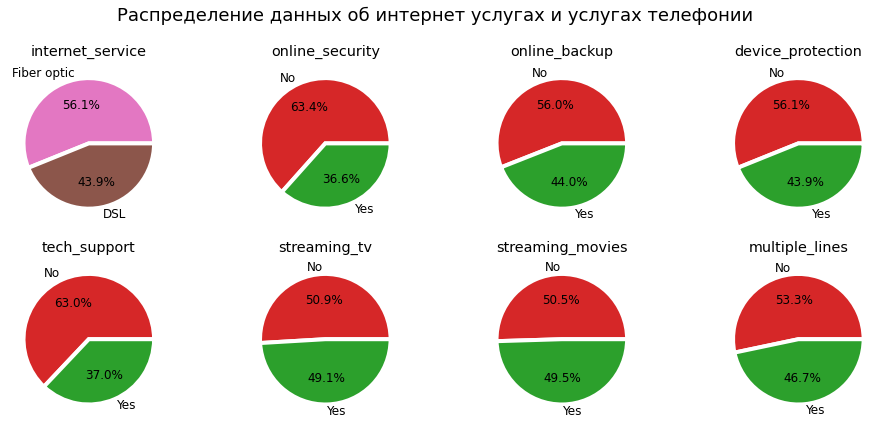

In [26]:
# распределение категориальных признаков
fig, axs = plt.subplots(2,4, figsize=(15,7))
fig.tight_layout(pad=5)
plt.subplots_adjust(hspace=.2, wspace=0.1)
fig.suptitle('Распределение данных об интернет услугах и услугах телефонии', fontsize=18)
for i,_ in enumerate(internet_new.columns):
    if i != 7:
        m = i // 4
        l = i % 4
        axs[m,l].pie(
            internet_new[_].value_counts(),
            labels=internet_new[_].value_counts().index,
            autopct='%1.1f%%',
            wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'},
            colors=[colors[key] for key in internet_new[_].value_counts().index]);
        axs[m,l].set_title(_)

axs[1,3].pie(
    phone_new.multiple_lines.value_counts(),
    labels=phone_new.multiple_lines.value_counts().index,
    autopct='%1.1f%%',
    wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'},
    colors=[colors[key] for key in phone_new.multiple_lines.value_counts().index]);
axs[1,3].set_title('multiple_lines');

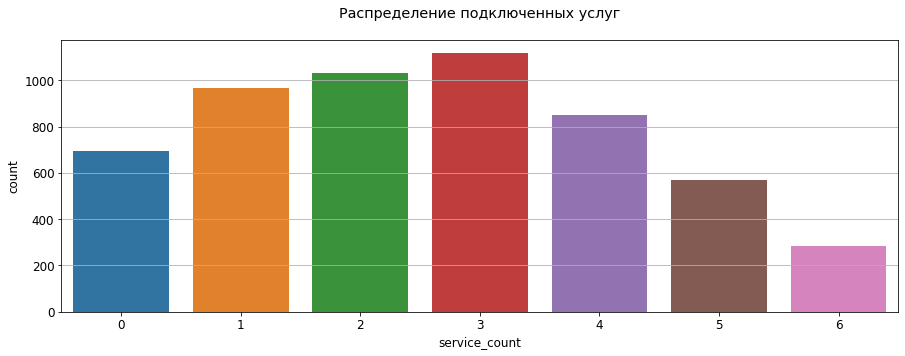

In [27]:
sns.countplot(internet_new['service_count'])
plt.title('Распределение подключенных услуг\n');

Распределение подключенных услуг имеет нормалный видю у клиентов чаще 3 подключенных услуги.

### Объединение таблиц

In [28]:
# объединим все таблицы how='outer'
data_full = contract_new.merge(personal_new, on='customerID', how='outer')
data_full = data_full.merge(internet_new, on='customerID', how='outer')
data_full = data_full.merge(phone_new, on='customerID', how='outer')
data_full.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service_count,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850,31.040,No,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,1.000,NaN
5575-GNVDE,One year,No,Mailed check,56.950,"2,071.840",No,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,2.000,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.850,226.170,No,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,2.000,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.300,"1,960.600",No,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,3.000,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.700,353.500,No,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,0.000,No


Выведем колонки с пропусками.

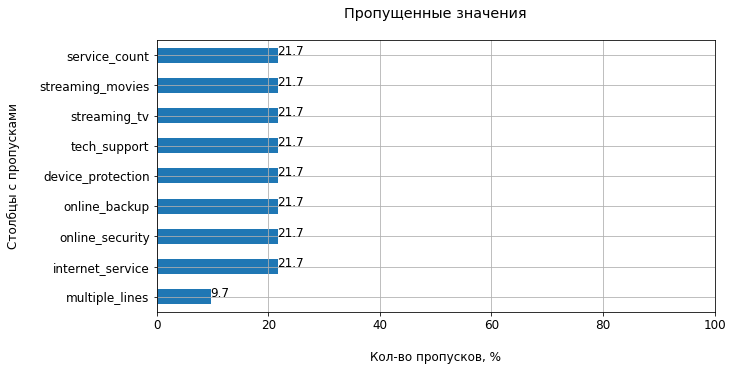

In [29]:
# проверим наличие пропусков в новом датафрейме
pass_columns = pass_value_barh(data_full)

In [30]:
# выведем возможные значения колонок с пропусками
data_info(data_full[pass_columns])

multiple_lines
['No' 'Yes' nan]
-------------------------------
internet_service
['DSL' 'Fiber optic' nan]
-------------------------------
online_security
['No' 'Yes' nan]
-------------------------------
online_backup
['No' 'Yes' nan]
-------------------------------
device_protection
['No' 'Yes' nan]
-------------------------------
tech_support
['No' 'Yes' nan]
-------------------------------
streaming_tv
['No' 'Yes' nan]
-------------------------------
streaming_movies
['No' 'Yes' nan]
-------------------------------
service_count
[ 1.  2.  3.  0.  4. nan  5.  6.]
-------------------------------


Пропуски в колонках с данными (`No`, `Yes`) стоит заполнить значениями `No`.

Пропуски `service_count` стоит заполнить `0`.

Для числовых характеристик замену стоит проводить медианным значением, так как их распределения смещены от среднего.

Пропуски `internet_service` стоит заполнить модой.

In [31]:
for _ in pass_columns:
    if _ != 'internet_service' and _ != 'service_count':
        data_full[_].fillna('No', inplace=True)
data_full['service_count'].fillna(0, inplace=True)
data_full['internet_service'].fillna(data_full['internet_service'].mode()[0], inplace=True)
data_info(data_full[pass_columns])

multiple_lines
['No' 'Yes']
-------------------------------
internet_service
['DSL' 'Fiber optic']
-------------------------------
online_security
['No' 'Yes']
-------------------------------
online_backup
['No' 'Yes']
-------------------------------
device_protection
['No' 'Yes']
-------------------------------
tech_support
['No' 'Yes']
-------------------------------
streaming_tv
['No' 'Yes']
-------------------------------
streaming_movies
['No' 'Yes']
-------------------------------
service_count
[1. 2. 3. 0. 4. 5. 6.]
-------------------------------


In [32]:
for _ in data_full.select_dtypes(include='object'):
    data_full[_] = data_full[_].astype('category')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   target             7043 non-null   category
 6   contract_duration  7043 non-null   int64   
 7   gender             7043 non-null   category
 8   senior_citizen     7043 non-null   category
 9   partner            7043 non-null   category
 10  dependents         7043 non-null   category
 11  internet_service   7043 non-null   category
 12  online_security    7043 non-null   category
 13  online_backup      7043 non-null   category
 14  device_protection  7043 non-null   category
 15  tech_support       7043 non-null   category
 

### Исследовательский анализ и предобработка данных объединённого датафрейма

Сравним распределение признаков среди клиентов, сгруппированных по целевому признаку.

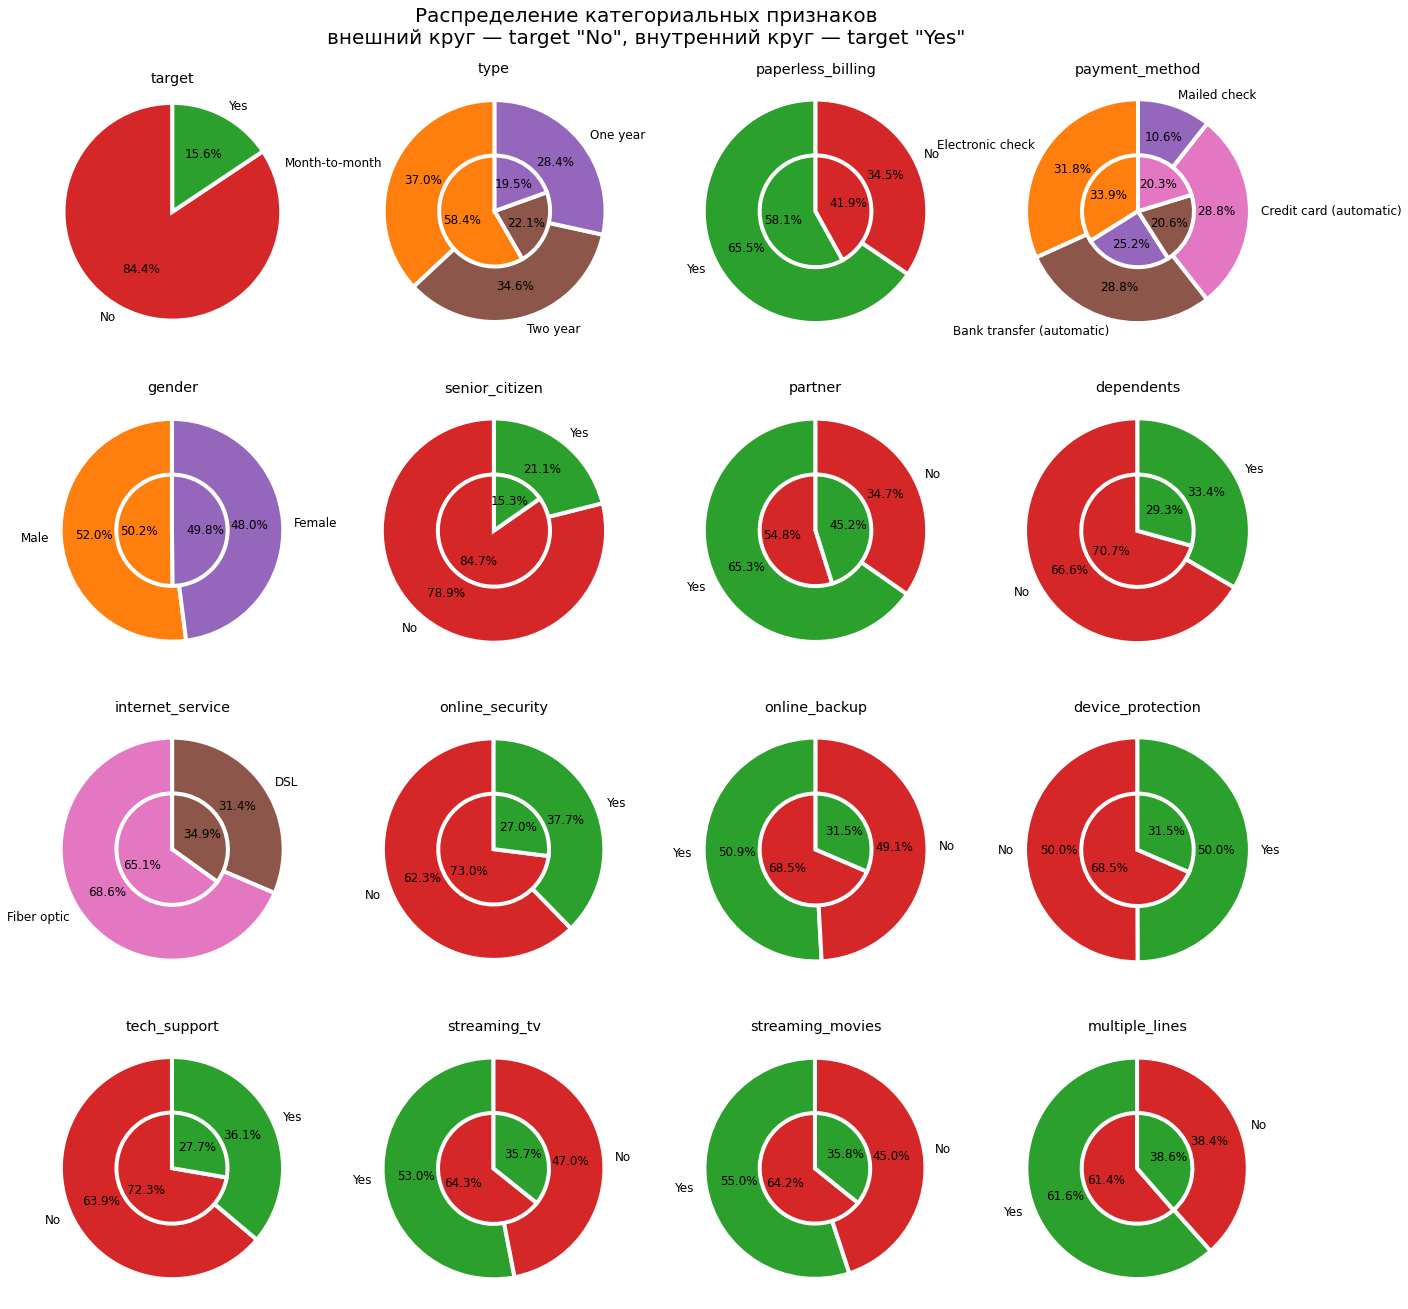

In [33]:
fig, axs = plt.subplots(4,4, figsize=(20,20))
fig.tight_layout(pad=8)
plt.subplots_adjust(hspace=0.2, wspace=0.3)
fig.suptitle('Распределение категориальных признаков\nвнешний круг — target "No", внутренний круг — target "Yes"', fontsize=20)

axs[0,0].pie(
    data_full['target'].value_counts(),
    labels=data_full['target'].value_counts().index,
    colors=[colors[key] for key in data_full['target'].value_counts().index],
    wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'},
    autopct='%1.1f%%', startangle=90, radius=1.1)
axs[0,0].set_title('target')
i = 1
for _ in data_full.select_dtypes(include=['category', 'object']):
    if _ != 'target':
        m = i // 4
        l = i % 4
        i += 1
        # Данные для первого пирога
        sizes1 = data_full.query('target == "Yes"')[_].value_counts()
        labels1 = data_full.query('target == "Yes"')[_].value_counts().index

        # Данные для второго пирога
        sizes2 = data_full.query('target == "No"')[_].value_counts()
        labels2 = data_full.query('target == "No"')[_].value_counts().index

        # Первый пирог (внешний)
        axs[m,l].pie(
            sizes1, labels=labels1, 
            colors=[colors[key] for key in labels1], 
            wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'},
            pctdistance=.7,
            autopct='%1.1f%%', startangle=90, radius=1.2)

        # Второй пирог (внутренний)
        axs[m,l].pie(
            sizes2,
            colors=[colors[key] for key in labels2],
            wedgeprops={'linewidth': 4.0, 'edgecolor': 'white'},
            autopct='%1.1f%%', startangle=90, radius=0.6)

        # Равные оси для правильного отображения
        axs[m,l].axis('equal')
        axs[m,l].set_title(_)


У большинства признаков, аггрегированных по целевому признаку, сохраняется распределение по классам. Для некоторых признаков наблюдается инверсия распределения по классам, так, ***чаще от услуг связи отказваются клиенты***:
    
1. `partner` — не состоящие в браке;
2. `online_backup` — без подключения облачного хранилища файлов для резервного копирования данных;
3. `streaming_tv` — без подключения стримингового телевидения;
4. `streaming_movies` — без подключения каталога фильмов;
5. ` multiple_lines` — без подключения телефона к нескольким линиям одновременно.

Из вида распределениия следующих признаков можно сказать:

6. `devise_protection` — среди оставшихся клиентов распределение (1 к 1), тогда как среди разорвавших контракт клиентов это же распределение (1 к 2); 
7. `payment_method` — имеет разные распределения по категорим.

Вероятнее всего, эти признаки являются наиболее значимыми из всех признаков со строковыми значениями.

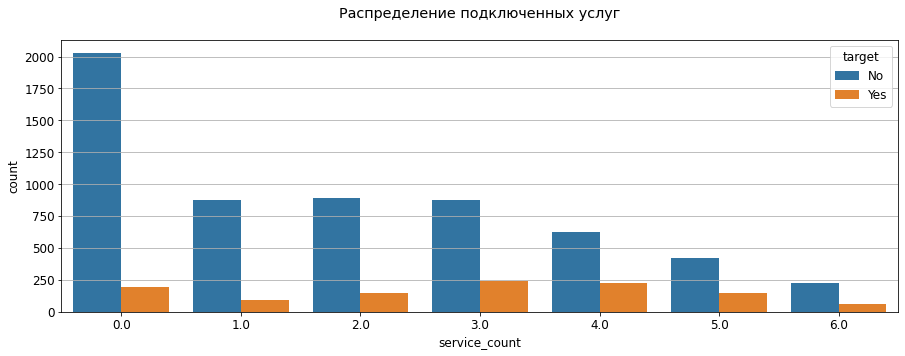

In [34]:
sns.countplot(data=data_full, x="service_count", hue='target')
plt.title('Распределение подключенных услуг\n');

Среди общего количества подключенных сервисов не наблюдается разительной разницы в распределениях клиентов, сгруппированных по таргету.

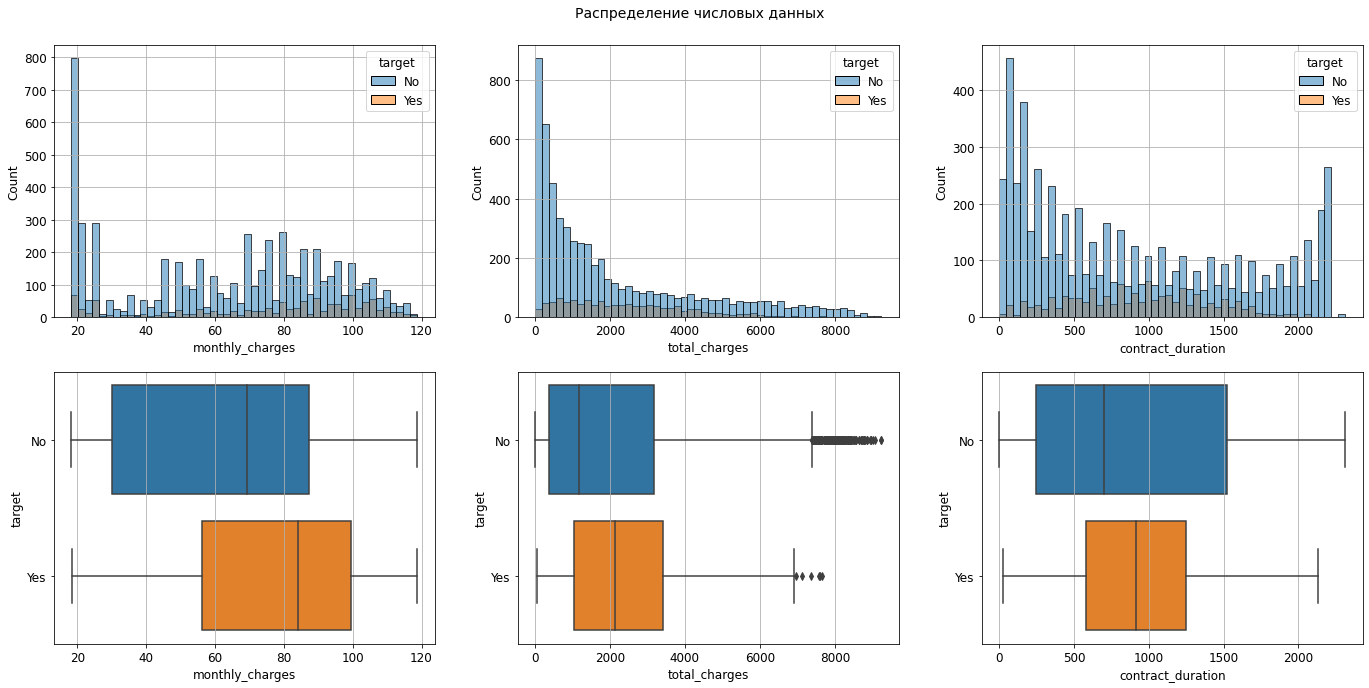

,monthly_charges,total_charges,contract_duration
0,69.200,"1,192.800",702.000
1,84.200,"2,139.030",915.000


In [35]:
nums = ['monthly_charges', 'total_charges', 'contract_duration']

fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.tight_layout(pad=4)
plt.subplots_adjust(hspace=0.2)
fig.suptitle('Распределение числовых данных')
df=pd.DataFrame(columns=nums)
for i,_ in enumerate(nums):
    sns.histplot(data_full, x=_, hue='target', bins=50, ax=ax[0,i])
    sns.boxplot(data=data_full, x=_, y='target', ax=ax[1,i])
    df[_] = [data_full.query('target == "No"')[_].median(), data_full.query('target == "Yes"')[_].median()]
plt.show()
display(df)

Исходя из графиков с квантилями распределений можно сказать, что:
1. клиенты, разорвавшие договор, ежемесячно платят за услуги больше оставшихся клиентов;
2. общая сумма трат клиентов, разорвавших договор, почти в 2 раза больше того же показателся среди оставшихся клиентов, что логично исходя из 1-го пункта;
3. при всем этом, разорвавшие контракт клиенты дольше были клиентами компании 2.5 года, против ~1.9 года.

Все эти признаки могут коррелировать с таргетом.

### Корреляционный анализ

Теперь посмотрим корреляцию признаков между собой, так как у нас много категориальных признаков, то используем матрицу из библиотеки `phik`.

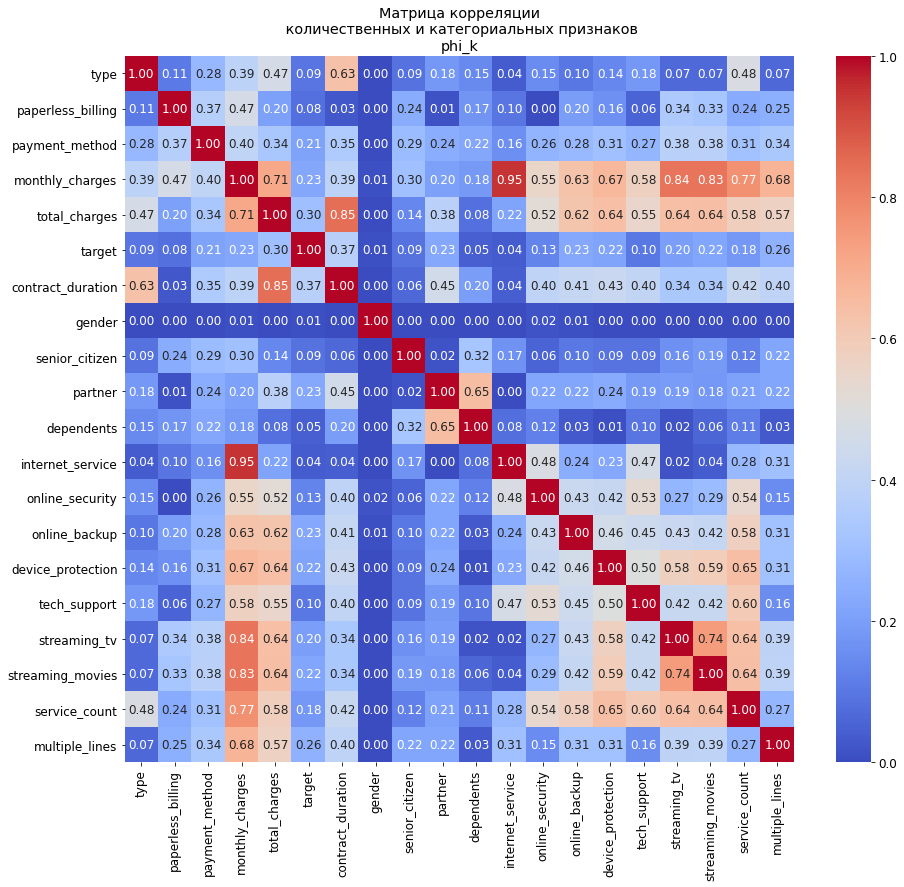

In [36]:
matrix = data_full.phik_matrix(interval_cols=nums)

plt.figure(figsize=(15,13))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f', )
plt.title('Матрица корреляции\n количественных и категориальных признаков\nphi_k')
plt.show()

In [37]:
data_full.shape

(7043, 20)

Из матрицы корреляции можно сказать, что:

1. Наблюдается высокая связь между ежемесячными платежами и интернет подключением.
2. Между признаками об оплате интернет услуг и признаками о подключенных услугах наблюдается средняя – средне-высокая взаимосвязь.
3. Но важнее всего отметить тот факт, что корреляция входных признаков с целевым достаточно низкая (< 0.2) для 9 из 19 признаков.


Таким образом, можно отметить 2 наиболее важных факта:

1. Признаки в более-менее высокими коэффициентами корреляции, как уже отмечалось ранее, являются:
    * `partner`
    * `online_backup` 
    * `streaming_tv`
    * `streaming_movies`
    * `multiple_lines`
    * `devise_protection`
    * `payment_method`
2. Признаки с тратами и длительностью действия контракта тоже имеют среднюю – средне-низкую корреляцию с целевым признаком.

Тогда, у нас в доступе будет 10 входных признаков более-менее коррелирующих с целевым.

In [38]:
# новый датафрейм с нужными колонками
data = data_full[[
    'payment_method', 'partner', 'online_backup', 'device_protection', 'streaming_tv',
    'streaming_movies', 'multiple_lines',
    'monthly_charges', 'total_charges', 'contract_duration', 
    'target'
]]
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

41


***Промежуточные выводы:***

1. Заполнены пропуски общих трат для новых клиентов (текущего месяца) значением ежемесячного платежа за услуги. Признаки, содержащие даты в чистом виде были удалены, из них был получен целевой признак, время действия контракта с клиентом. Пропуски, образовавшиеся ходе объединения таблиц, в колонках с подключенными услугами были заполнены `"No"`.


2. В ходе иследовательского анализа выявлен портрет клиента, разорвавшего договор. Человек, который не состоит в браке, у клиента **не подключены опции**: облачного хранилища, стримингового ТВ, каталога фильмов, подключения телефона к нескольким линиям, антивируса. Также можно отметить то, что:
    * у клиентов, разорвавших договор, ежемесячные траты в среднем больше трат оставшихся клиентов (84.2 против 69.2);
    * общая сумма трат клиентов, разорвавших договор, также больше трат оставшихся клиентов (2139 против 1192);
    * клиенты, разорвавшие контракт, в среднем дольше были клиентами компании 2.5 года, против ~1.9 года среди оставшихся клиентов.
    
    

3. Из 20 подготовленных признаков всего 10 более или менее коррелируют с целевым признаком: наличие партнера, опция облачного хранилища, опция стримингового ТВ, опция стриминга фильмов, опция подключения телефона к нескольким линиям, опция антивируса, тип платежа, ежемесячные и общие траты клиентов на услуги, длительность действия контракта.

## Подготовка данных

In [39]:
# разделим данные на тренировочную и тестовую выборку
# стратифицируем по таргету
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target'])
# выведем размерности выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5251, 10), (1751, 10), (5251,), (1751,))

In [40]:
# кодируем целевой признак
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [41]:
# категориальные и численные признаки
ohe_cols = X_train.select_dtypes(include="category").columns.tolist()
num_cols = X_train.select_dtypes(exclude="category").columns.tolist()
ohe_cols, num_cols

(['payment_method',
  'partner',
  'online_backup',
  'device_protection',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines'],
 ['monthly_charges', 'total_charges', 'contract_duration'])

In [42]:
# трансформация признаков
preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [43]:
# пайплайн для линейной модели
pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', 'passthrough')
    ]
)

Для обучения модели `CatBoostClassifier` кодирование и масштабирование не требуется.

## Обучение моделей машинного обучения

In [44]:
# создадим датафрейм, в который будем записывать результаты подбора гиперпараметров
models_results = pd.DataFrame(columns=['model_name', 'params', 'roc_auc', 'recall', 'time'])

In [45]:
# случайная модель
model_dummy = DummyClassifier()

# модель логистической регрессии
model_logreg = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, solver='liblinear')
# сетка LogisticRegression
param_grid_logreg = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [.01, .1, 1, 10, 100],
}

# модель градиентного бустинга catboost
model_cat = CatBoostClassifier(
    auto_class_weights ='Balanced', loss_function='Logloss', 
    verbose=0, random_state=RANDOM_STATE, early_stopping_rounds=50,
    cat_features=ohe_cols,
)
# сетка CatBoostClassifier
param_grid_cat = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.1, 0.25, 0.5],
    'depth': [3,6,9],
}

### Случайная модель

In [46]:
pipe.set_params(model=model_dummy).fit(X_train, y_train)
print(f'ROC-AUC score Train: {roc_auc_score(y_train, pipe.predict(X_train))}')
models_results = models_results.append(
    {
        'model_name': 'DummyClassifier',
        'params': 'none', 
        'roc_auc': roc_auc_score(y_train, pipe.predict(X_train)),
        'recall': 'none',
        'time': 'none'
    },
    ignore_index=True)

ROC-AUC score Train: 0.5


### LogisticRegression

In [47]:
cv_logreg_1 = gscv_fit(
#     пайнлайн подготовки данных и модель дерева решений
    pipe.set_params(model=model_logreg), 
#     гиперпараметры для модели
    param_grid_logreg,
#     название модели
    model_name='LogisticRegression')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'model__C': 1, 'model__penalty': 'l1'}",0.177,0.729,0.011,0.640,3
2,"{'model__C': 10, 'model__penalty': 'l2'}",0.149,0.729,0.011,0.638,5
3,"{'model__C': 100, 'model__penalty': 'l2'}",0.208,0.729,0.011,0.638,5
4,"{'model__C': 100, 'model__penalty': 'l1'}",0.215,0.729,0.011,0.638,5
5,"{'model__C': 10, 'model__penalty': 'l1'}",0.158,0.729,0.011,0.638,5


-------------------


У всех моделей одинаковый скор, небольшое отличие наблюдается в результатах рекол скор. Можно попробовать подобрать параметры, чтобы улучшить модель, добавим промежуточные значения для параметра `C`.

In [48]:
param_grid_logreg

{'model__penalty': ['l1', 'l2'], 'model__C': [0.01, 0.1, 1, 10, 100]}

In [49]:
cv_logreg_2 = gscv_fit(
#     пайнлайн подготовки данных и модель дерева решений
    pipe.set_params(model=model_logreg), 
#     гиперпараметры для модели
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.05, 0.5, 5, 50],
    },
#     название модели
    model_name='LogisticRegression')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'model__C': 5, 'model__penalty': 'l2'}",0.178,0.729,0.011,0.638,3
2,"{'model__C': 5, 'model__penalty': 'l1'}",0.185,0.729,0.011,0.638,3
3,"{'model__C': 50, 'model__penalty': 'l2'}",0.207,0.729,0.011,0.638,3
4,"{'model__C': 50, 'model__penalty': 'l1'}",0.182,0.729,0.011,0.638,3
5,"{'model__C': 0.5, 'model__penalty': 'l1'}",0.212,0.729,0.011,0.638,3


-------------------


Ни целевой скор, ни реколл скор не улучшились, тут уже ничем не помочь.

### CatBoostClassifier

In [50]:
cv_catboost_1 = gscv_fit(
#     модель
    model_cat,
#     гиперпараметры для модели
    param_grid_cat,
#     название модели
    model_name='CatBoostClassifier'
)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'depth': 3, 'iterations': 1500, 'learning_rate': 0.25}",5.211,0.903,0.006,0.674,7
2,"{'depth': 3, 'iterations': 1000, 'learning_rate': 0.25}",3.875,0.903,0.007,0.689,5
3,"{'depth': 3, 'iterations': 1500, 'learning_rate': 0.5}",5.276,0.902,0.010,0.654,10
4,"{'depth': 3, 'iterations': 1000, 'learning_rate': 0.5}",3.849,0.902,0.011,0.665,8
5,"{'depth': 3, 'iterations': 1500, 'learning_rate': 0.1}",5.361,0.902,0.007,0.713,4


-------------------


In [51]:
param_grid_cat

{'iterations': [500, 1000, 1500],
 'learning_rate': [0.1, 0.25, 0.5],
 'depth': [3, 6, 9]}

Целевые метрики лучших параметров достаточно близки, значительное отличие наблюдается в значениях второй метрики. При значении метрики `learning_rate` равном 0.1 наблюдается значительное ухудшение второй метрики с сохранением целевой метрики.

В топ-5 параметров попали:
    
* только глубина 3. Попробуем еще глубину 4.
* [1000, 1500] итераций и скорость (шаг) обучения [0.25, 0.5], при 1500 итерациях время обучения дольше, что логичо. Попробуем уменьшить кол-во итераций и выберем между [1000, 1250].

Добавим коэффициент регуляризации `l2_leaf_reg`.

In [52]:
cv_catboost_2 = gscv_fit(
#     модель
    model_cat,
#     гиперпараметры для модели
    {
        'depth': [3,4],
        'iterations': [1000, 1250],
        'learning_rate': [0.25, 0.5],
        'l2_leaf_reg': [1, 10, 100],
    },
#     название модели
    'CatBoostClassifier'
)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 10, 'learning_rate': 0.25}",4.496,0.902,0.006,0.688,8
2,"{'depth': 3, 'iterations': 1000, 'l2_leaf_reg': 10, 'learning_rate': 0.25}",3.942,0.902,0.007,0.701,7
3,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 1, 'learning_rate': 0.25}",4.350,0.902,0.009,0.668,13
4,"{'depth': 3, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.25}",3.608,0.901,0.011,0.673,11
5,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 10, 'learning_rate': 0.5}",4.781,0.900,0.006,0.667,14


-------------------


Из данных с топ-5 моделей:

* лучше модели с глубиной 3, 1250 итераций чуть лучше (исходя из значений целевой метрики);
* при `learning_rate` == 0.25 целевая метрика лучше;
* при значениях `l2_leaf_reg` снижается реколл. Можно попробовать подобрать этот параметр.

In [53]:
cv_catboost_3 = gscv_fit(
#     модель
    model_cat,
#     гиперпараметры для модели
    {
        'iterations': [1250],
        'learning_rate': [0.25],
        'depth': [3],
        'l2_leaf_reg': [.1, .5, 1, 5, 10, 50],
    },
#     название модели
    'CatBoostClassifier'
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 5, 'learning_rate': 0.25}",4.645,0.903,0.008,0.673,3
2,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 10, 'learning_rate': 0.25}",4.506,0.902,0.006,0.688,2
3,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 1, 'learning_rate': 0.25}",4.644,0.902,0.009,0.668,4
4,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 0.5, 'learning_rate': 0.25}",4.419,0.901,0.009,0.666,5
5,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 0.1, 'learning_rate': 0.25}",4.301,0.900,0.009,0.659,6


-------------------


Стоит попробовать подобрать `l2_leaf_reg` в интервале [4, 10), хоть в этом интервале хуже вторая метрика, но лучше целевая.

In [54]:
cv_catboost_4 = gscv_fit(
#     модель
    model_cat,
#     гиперпараметры для модели
    {
        'iterations': [1250],
        'learning_rate': [0.25],
        'depth': [3],
        'l2_leaf_reg': range(4,10),
    },
#     название модели
    'CatBoostClassifier'
)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV fits


,params,mean_fit_time,mean_test_roc_auc,std_test_roc_auc,mean_test_recall,rank_test_recall
rank_test_roc_auc,,,,,,
1,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 8, 'learning_rate': 0.25}",4.689,0.905,0.007,0.688,2
2,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 7, 'learning_rate': 0.25}",4.690,0.904,0.009,0.684,3
3,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 6, 'learning_rate': 0.25}",4.588,0.903,0.007,0.690,1
4,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 4, 'learning_rate': 0.25}",4.610,0.903,0.006,0.676,4
5,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 9, 'learning_rate': 0.25}",4.556,0.903,0.008,0.668,6


-------------------


Получилось улучшить целевую метрику на тренировочных данных. Теперь попробуем сравнить все модели между собой.

## Выбор лучшей модели

In [55]:
# выведем таблицу с лучшими гиперпараметрами
models_results

,model_name,params,roc_auc,recall,time
0,DummyClassifier,none,0.500,none,none
1,LogisticRegression,"{'model__C': 1, 'model__penalty': 'l1'}",0.729,0.640,0.133
2,LogisticRegression,"{'model__C': 5, 'model__penalty': 'l2'}",0.729,0.638,0.211
3,CatBoostClassifier,"{'depth': 3, 'iterations': 1500, 'learning_rate': 0.25}",0.903,0.674,6.994
4,CatBoostClassifier,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 10, 'learning_rate': 0.25}",0.902,0.688,6.167
5,CatBoostClassifier,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 5, 'learning_rate': 0.25}",0.903,0.673,6.012
6,CatBoostClassifier,"{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 8, 'learning_rate': 0.25}",0.905,0.688,6.123


`CatBoostClassifier` выделяется своей высокой метрикой roc-auc. Построим рок кривую для модели под 6 номером в таблице.

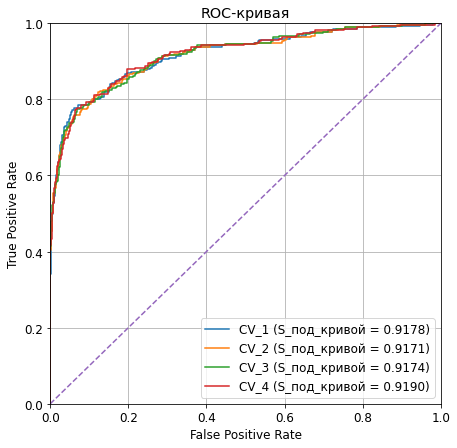

In [56]:
# ROC кривая
plt.figure(figsize=(7,7))

for i,cv in enumerate([cv_catboost_1, cv_catboost_2, cv_catboost_3, cv_catboost_4]):
    fpr, tpr, thresholds = roc_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, linestyle='-', label=f'CV_{i+1} (S_под_кривой = %0.4f)' % auc(fpr, tpr))
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая');

4 модель catboost оказалась лучшей, проверим ее на тестовых данных.

In [57]:
best_model = cv_catboost_4.best_estimator_
bm_test_preds = best_model.predict(X_test)
bm_test_probs = best_model.predict_proba(X_test)[:,1]

In [58]:
f"ROC-AUC on test data: {roc_auc_score(y_test, bm_test_preds):.3f}"

'ROC-AUC on test data: 0.853'

Целевая точность предсказания достигнута. Посмотрим матрицу ошибок и важность признаков.

recall: 0.775, precision: 0.678


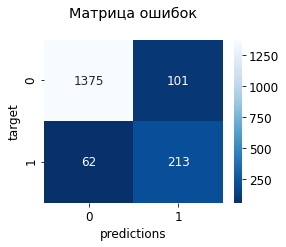

In [59]:
cm = confusion_matrix(y_test, bm_test_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок\n')
plt.xlabel('predictions')
plt.ylabel('target');
print(f"recall: {recall_score(y_test, bm_test_preds):.3f}, precision: {precision_score(y_test, bm_test_preds):.3f}")

Таким образом, на тестовых данных модель предсказала 22.5% ложноотрицательными и 32.2% ложноположительными.

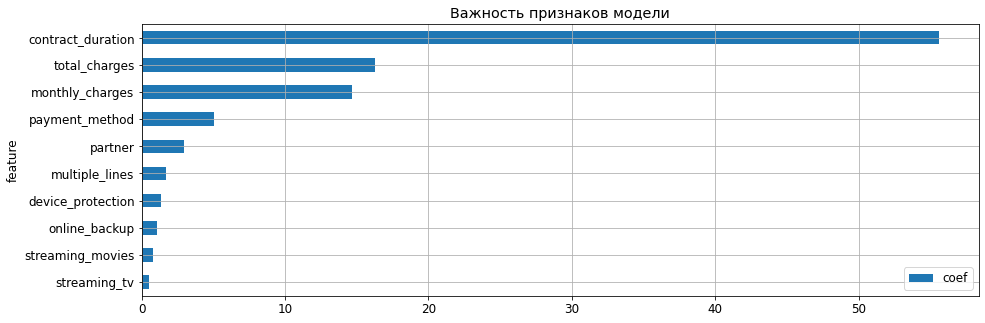

In [60]:
cf = pd.DataFrame({
    'coef': best_model.feature_importances_,
    'feature': best_model.feature_names_
}).sort_values(by='coef')

cf.plot(kind='barh', x='feature')
plt.title(f'Важность признаков модели');

Наиболее значимыми признаком для модели оказался признак:
* длительность контракта (в днях) `contract_duration`.

Далее идут такие признаки как:
* общие расходы клиента `total_charges`
* ежемесячные расходы клиента `monthly_charges`

Чуть менее значимыми оказались:
* способ оплаты `payment_method`
* наличие и супруга / супруги `pаrtner`
* подключение телефона к нескольким линиям одновременно `multiple_lines`
* услуга антивируса `device_protection`
* облачное хранилище файлов для резервного копирования данных `online_backup`
* каталог фильмов `streaming_movies`
* стриминговое телевидение `streaming_tv`

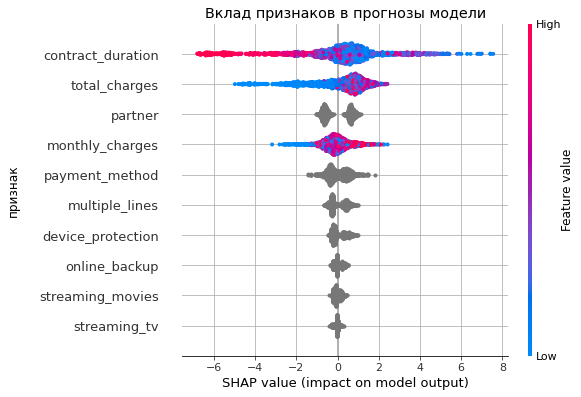

In [61]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.title('Вклад признаков в прогнозы модели')
plt.ylabel('признак\n');

Чем выше значение длительности ниже вклад признака в результаты предсказания модели.

Чем ниже значение общих трат клиента, тем ниже вклад в предсказания.

## Заключение

*Предобработка и анализ данных:*

1. Данные из 4 таблиц были объединены по идентификатору клиентов.
2. Проведен исследовательский анализ даных. Были добавлены следующие признаки: кол-во подключенных услуг, целевой признак из "end_date", признак с количеством дней действия договора (текущим, для действующих клиентов и общим для клиентов, разорвавших договор). Выявлено, что по целевому признаку наблюдается диссбаланс классов ~15% к ~85%.
3. Все таблицы были объединены. Образовавшиеся пропуски были заполнены значением "No" для подключенных услуг, "0" для количества подключенных услуг и модой для типа подключения.
4. В ходе исследования объединенного датафрейма были выявлены признаки, которые отличаются для действующих клиентов и разорвавших контракт клиентов.
    * признаки `partner`, `online_backup`, `streaming_tv`, `streaming_movies`, ` multiple_lines` имеют противоположные распределения по значениям ("Yes" и "No");
    * признаки `devise_protection`, `payment_method`имеют разные распределения между 3 и 4 категориями соответственно;
    * признаки `monthly_charges`, `total_charges` имеют бóльшие медианные значения среди разорвавших договор клиентов;
    * медианные значения признака `contract_duration` для клиентов из разных групп также отличаются: 2.5 года для разорвавших контракт клиентов, против 1.9 года для клиентов из второй группы.
5. Анализ корреляции признаков также показал, что именно эти признаки больше всего коррелируют с целевым признаком (коэффициент корреляции более 0.2).

*Подготовка данных:*

1. Данные были разделены на 2 выборки с применением стратификации по таргету (тестовая выборка 25% данных).

2. Целевой признак был закодирован LabelEncoder'ом. 

3. Для обучения модели LogisticRegression данные были закодированы OneHotEncoder'ом, а количественные признаки масштабированы StandartScaler'ом.

4. Для обучения модели градиентого бустинга CatBoostClassifier подготовка данных не необходима, так как модель сама эти занимается при указании категориальных признаков.

*Результаты обучения моделей:*

Модель градиентного бустинга `CatBoostClassifier` хорошо справилась с тестовыми данными, метрика **`AUC-ROC`** предсказаний модели составила **0.853**.

**Модель:**
```python
CatBoostClassifier(
    auto_class_weights ='Balanced', loss_function='Logloss', early_stopping_rounds=50,
    verbose=0, random_state=RANDOM_STATE,
    cat_features=[
        'payment_method',  'partner', 'online_backup', 'device_protection',
        'streaming_tv', 'streaming_movies', 'multiple_lines'
    ]
)
```

**Гиперпараметры модели:**
```python
{'depth': 3, 'iterations': 1250, 'l2_leaf_reg': 8, 'learning_rate': 0.25}
```

**Признаки, использовавшиеся во время обучения:**
```python
['payment_method', 'partner', 'online_backup', 'device_protection',
 'streaming_tv', 'streaming_movies', 'multiple_lines', 'monthly_charges',
 'total_charges', 'contract_duration']
 ```

Анализ матрицы ошибок тестовых данных показал, что модель в 22.5% случаев дает ложно-отрицательный ответ и в 32.2% случаем ответ оказывается ложно-положительными.Таким образом, модель совершает меньше ошибок второго рода (чем первого рода), которые с точки зрения задачи бизнеса являются критическими, ведь ложно предсказать уход клиента не так критично, как совсем не распознать его.

*Рекомендации:*

Для повышения точности прогнозов и улучшения качества модели следует увеличить размер датасета: чем больше естественных данных увидит модель, тем лучше сможет обучиться, например, будет лучше обобщать данные или находить неявные закономерности.